# Classifying with artificial neurons

## Introduction: The perceptron

The first example of this notebook is a binary classifier by means of the Logistic Regression operation. This model is also called Perceptron or Artificial Neuron, depicted in the figure below.

![perceptron](assets/perceptron.png)

There we have a set of inputs {x1, x2, x3}, a set of weights {w1, w2, w3}, a bias factor {b} and an activation function {f}, and the following operations are applied:

$$y = f(\sum_{m=1}^{M} x_i * w_i + b)$$

To actually make it a binary classifier we must place a specific type of activation function called Sigmoid: 

$$\sigma(z) = \frac{1}{(1 + {e}^{-z})}$$ where $$z = x * w + b$$

The Sigmoid shape is depicted in the figure below:

![sigmoid](assets/sigmoid.png)

We can see how, depending on the weights and biases (in the depicted figure all sigmoids have scalar values, so only one input x1 would be injected) there is a ridge bounding the outputs between (0, 1), which can be interpreted as a probability output depending on the inputs that activate it.

## Exercise 1: It is a number or is it noise?

In this example we will classify whether an image is noise or a MNIST digit:
* MNIST dataset contains images of 10 handwritten digit classes {0, 1, 2, 3, 4, ..., 9}. Each class contains 6.000 images of 28x28 pixels.

We will use 50.000 images for training and 10.000 for testing our classification.

In [1]:
# import print utility and timer
from __future__ import print_function
import timeit
# First import tensorflow and the data reader
from tensorflow.examples.tutorials.mnist import input_data
import tensorflow as tf
# numpy for matrix utilities
import numpy as np
from utils import plot_samples
# import plot utilities
import matplotlib.pyplot as plt
% matplotlib inline

Using TensorFlow backend.


In [2]:
# define IMG dimensions
IMG_SIZE=28
# Import mnist data
mnist = input_data.read_data_sets('data/mnist/', one_hot=True)
# Make the random images generator (28x28 withdrawn from a random uniform distribution)
def make_random_batch(batch_size):
    # Generate batch_size images of size image_size x image_size
    rimg = np.random.uniform(low=0., high=1., size=(batch_size, IMG_SIZE * IMG_SIZE))
    return rimg
# Define num of pixels that will be input to models
unrolled_size = IMG_SIZE * IMG_SIZE
print("Computed unrolled size: ", unrolled_size)

Extracting data/mnist/train-images-idx3-ubyte.gz
Extracting data/mnist/train-labels-idx1-ubyte.gz
Extracting data/mnist/t10k-images-idx3-ubyte.gz
Extracting data/mnist/t10k-labels-idx1-ubyte.gz
Computed unrolled size:  784


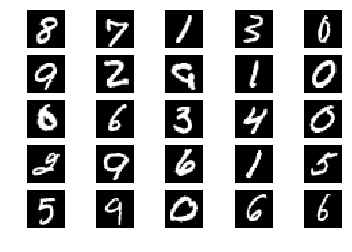

In [3]:
# Let's visualize some MNIST samples
batch_x_real, _ = mnist.train.next_batch(100)
batch_x_real = batch_x_real.reshape((100, 28, 28))
plot_samples(batch_x_real)

In [4]:
# Prepare the model, recall logistic regression equation
# Define weights matrix (from unrolled_size inputs to 1 classification output (noise(0)/mnist(1)))
W = tf.Variable(tf.zeros([unrolled_size, 1]))
# the bias is summing just a scalar output, so dimension 1
b = tf.Variable(tf.zeros([1]))
# define an input placeholder to inject the vectorized images
# None indicates we don't know batch_size yet, will be specified when running the training
x = tf.placeholder(tf.float32, [None, unrolled_size]) 
# equation implementation
y = tf.matmul(x, W) + b
# apply sigmoid to get final predictions
out = tf.sigmoid(y)

# Now we define the placeholder to place the flag (0 or 1) as output examples
y_ = tf.placeholder(tf.float32, [None, 1])

# Now call the sigmoid cross entropy with logits to compute the loss function
loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(y, y_))

# define the gradients update operation with learning rate of 0.05
train_step = tf.train.GradientDescentOptimizer(0.05).minimize(loss)

In [5]:
# initialize the TensorFlow session to run the operations Graph "on the fly" (not usual in production code)
sess = tf.InteractiveSession()
tf.global_variables_initializer().run()

# specify number of epochs to run through whole dataset
num_epochs = 1 # approx 55 s / epoch on laptop (macbook pro 13" i7 end 2011 w/ 8GB RAM) w/ batch_size = 10
# compute total amount of batches to be run
train_size = 50000
num_batches = int(train_size * num_epochs)
# specify batch_size 
batch_size = 10
# print loss after this amount of batches
print_every = 10000
tr_losses = []

print('Training...')
beg_t = timeit.default_timer()
# Run the training iterations
for curr_batch in range(num_batches):
    # get the batch of training images (to be injected to x placeholder)
    batch_x_real, _ = mnist.train.next_batch(batch_size)
    # create the batch of labels (to be injected to y_ placeholder)
    batch_y_real = np.ones((batch_size, 1))
    # generate the batch of random images (to be injected to x placeholder)
    batch_x_random = make_random_batch(batch_size)
    # create the batch of 0 labels (to be injectd to y_ placeholder)
    batch_y_random = np.zeros((batch_size, 1))
    # merge both batches into one and run update
    batch_x = np.concatenate((batch_x_real, batch_x_random), axis=0)
    batch_y = np.concatenate((batch_y_real, batch_y_random), axis=0)
    # run model update (learning stage over a batch of samples)
    tr_loss , _= sess.run([loss, train_step], feed_dict={x: batch_x, y_:batch_y})
    tr_losses.append(tr_loss)
    if (curr_batch + 1) % print_every == 0:
        print('Batch {}/{} training loss: {:.6f}'.format(curr_batch + 1, num_batches, tr_loss))
end_t = timeit.default_timer()
print('Total time training {} epochs: {} s'.format(num_epochs, end_t - beg_t))

Training...
Batch 10000/50000 training loss: 0.000142
Batch 20000/50000 training loss: 0.000212
Batch 30000/50000 training loss: 0.000053
Batch 40000/50000 training loss: 0.000171
Batch 50000/50000 training loss: 0.000019
Total time training 1 epochs: 76.7494912148 s


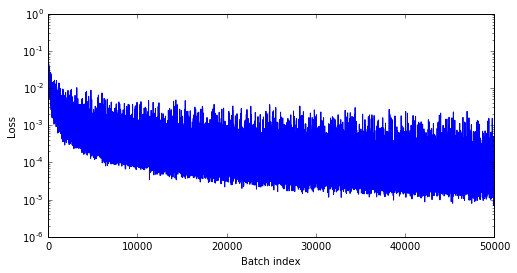

In [71]:
plt.figure(figsize=(8, 4))
plt.semilogy(tr_losses)
plt.xlabel('Batch index')
plt.ylabel('Loss')

In [72]:
# Test trained model
# generate the random test images
te_x_random = make_random_batch(10000)
te_y_random = np.zeros((10000, 1))
# cache the real test images
te_x_real = mnist.test.images
te_y_real = np.ones((10000, 1))
# total test batches
te_x_batch = np.concatenate((te_x_random, te_x_real), axis=0)
te_y_batch = np.concatenate((te_y_random, te_y_real), axis=0)
# define the accuracy computation op
# NOTE: the sigmoid output is rounded so that if out >= 0.5 --> predicts 1, otherwise predicts 0
correct_prediction = tf.equal(tf.round(out), y_)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
print('Accuracy in classifying real/fake '
      'mnist: {}'.format(sess.run(accuracy, feed_dict={x:te_x_batch, y_:te_y_batch})))

Accuracy in classifying real/fake mnist: 1.0


## Exercise 2: What number is it? Scaling up to multiple classes
Now that a binary classification task has been solved we will see its natural extension: a multiclass classifier.
This can be done by means of a softmax layer. The softmax layer is a parallel arrangement of sigmoidal neurons (*Output Layer* in the image below), where every neuron indicates the amount of probability that the input features (*Input Layer* in the image below) belong to a certain class.

![softmax](assets/softmax_img.png)


As it is a probability distribution between the possible classes, all of them must sum up to 1. So the softmax formulation is the following one:

$$y = \frac{e^{x^T * w_k}}{\sum_{n=1}^{N} e^{x^T * w_n}}$$

where x and w are vectors representing inputs $x$ and k-th layer weights $w_k$ .

In [73]:
# initialize the TensorFlow session to run the operations Graph "on the fly" (not usual in production code)
sess = tf.InteractiveSession()

In [74]:
# TODO: cell to be done by the student
# First, define the new weights and biases to express the multiple output neurons
# Define weights matrix (from unrolled_size inputs to 10 classification outputs (10 MNIST digits)
W = tf.Variable(tf.zeros([unrolled_size, 10])) # DEFINED BY STUDENT
# define the biases
b = tf.Variable(tf.zeros([10])) # DEFINED BY STUDENT
# define an input placeholder to inject the vectorized images
x = tf.placeholder(tf.float32, [None, unrolled_size]) # DEFINED BY STUDENT 
# equation implementation
y = tf.matmul(x, W) + b # DEFINED BY STUDENT
# apply sigmoid to get final predictions
out = tf.nn.softmax(y) # DEFINED BY STUDENT

# Now we define the placeholder to place the classes
y_ = tf.placeholder(tf.float32, [None, 10]) # DEFINED BY STUDENT

# Now call the softmax cross entropy with logits to compute the loss function
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y, y_)) # DEFINED BY STUDENT

# define the gradients update operation with learning rate of 0.05
train_step = tf.train.GradientDescentOptimizer(0.05).minimize(loss) # DEFINED BY STUDENT

In [78]:
tf.global_variables_initializer().run()

# specify number of epochs to run through whole dataset
num_epochs = 3 # approx xxx s / epoch on laptop (macbook pro 13" i7 end 2011 w/ 8GB RAM) w/ batch_size = 100
# compute total amount of batches to be run
train_size = 50000
num_batches = int(train_size * num_epochs)
# specify batch_size 
batch_size = 100
# print loss after this amount of batches
print_every = 10000

tr_losses = []
print('Training...')
beg_t = timeit.default_timer()
# Run the training iterations
for curr_batch in range(num_batches):
    # get the batches of training images (injected to x placeholder) and labels (injected to y_ placeholder)
    batch_x, batch_y = mnist.train.next_batch(batch_size)
    # run model update (learning stage over a batch of samples)
    tr_loss , _= sess.run([loss, train_step], feed_dict={x: batch_x, y_:batch_y})
    tr_losses.append(tr_loss)
    if (curr_batch + 1) % print_every == 0:
        print('Batch {}/{} training loss: {:.6f}'.format(curr_batch + 1, num_batches, tr_loss))
end_t = timeit.default_timer()
print('Total time training {} epochs: {} s'.format(num_epochs, end_t - beg_t))

Training...
Batch 10000/150000 training loss: 0.339438
Batch 20000/150000 training loss: 0.159393
Batch 30000/150000 training loss: 0.264798
Batch 40000/150000 training loss: 0.241589
Batch 50000/150000 training loss: 0.244631
Batch 60000/150000 training loss: 0.378915
Batch 70000/150000 training loss: 0.337105
Batch 80000/150000 training loss: 0.403336
Batch 90000/150000 training loss: 0.225185
Batch 100000/150000 training loss: 0.212687
Batch 110000/150000 training loss: 0.286771
Batch 120000/150000 training loss: 0.151247
Batch 130000/150000 training loss: 0.211452
Batch 140000/150000 training loss: 0.154787
Batch 150000/150000 training loss: 0.161127
Total time training 3 epochs: 312.552354097 s


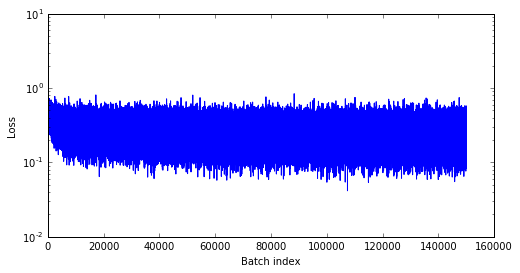

In [79]:
plt.figure(figsize=(8, 4))
plt.semilogy(tr_losses)
plt.xlabel('Batch index')
plt.ylabel('Loss')

In [81]:
# Test trained model
# cache the real test images and labels
te_x_batch = mnist.test.images
te_y_batch = mnist.test.labels
# define the accuracy computation op
# NOTE: must take the argmax of prediction at softmax output to get predicted class with more probability
# Argmax also done in y_ to get index out of one-hot vector
correct_prediction = tf.equal(tf.argmax(out, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
print('Accuracy in classifying '
      'mnist digits: {}'.format(sess.run(accuracy, feed_dict={x:te_x_batch, y_:te_y_batch})))

Accuracy in classifying mnist digits: 0.926500022411
